# Imports


In [ ]:
# Do this or put the code/notebook directly in the same directory as 'splineop' 
import sys
sys.path.append("../")
# Imports
from splineop import splineop as spop
from scipy.interpolate import make_lsq_spline
import matplotlib.pyplot as plt
import numpy as np 

# Load data

In [3]:
y_obs = np.loadtxt("./example-signal.csv",
               delimiter=",")

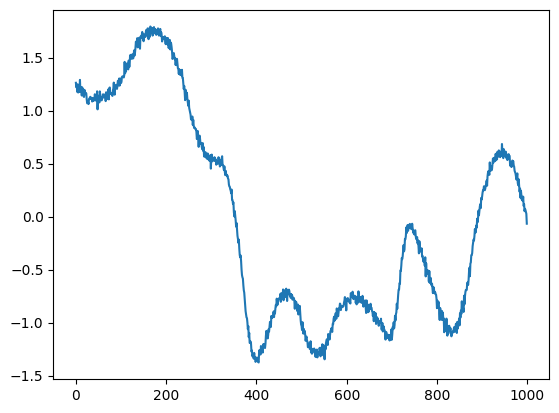

In [4]:
plt.plot(y_obs)
plt.show()

# General usage 

In [41]:
# Define a cost and model
cost = spop.costConstrained()
model = spop.splineOPConstrained(cost)

# Generarte states and speeds from observed data
states = spop.state_generator(y_obs, n_states=5, pct=0.05)
speeds = spop.compute_speeds_from_observations(y_obs)

# Pre-compute quantities used in cost function
model.fit(y_obs, 
        states,
        speeds, 
        True)

# Compute costs and backtrack solution
model.predict(13)

In [47]:
model.bkps # Show predicted breakpoints. Note that they are stored as indices over the signal.

array([121, 250, 316, 370, 419, 503, 560, 625, 688, 717, 749, 814, 873])

# Plot prediction

In [ ]:
x = np.linspace(0,1,1000,False) # Support for the prediction
b = np.array(model.bkps/1000) # Convert to [0,1] scale; i.e. 1000 = number of samples

# Generate knots from change points
## Knots for the spline require addition of extreme points
## to ensure smoothness
t = np.hstack(
        (np.array([0, 0, 0]), b)
    ) 
t = np.hstack((t, np.array([1, 1, 1]))) 

# Compute predicted polynomial
predicted_polynomial = make_lsq_spline(x=x,
                                        y=y_obs,
                                        t=t,
                                        k=2)

[]

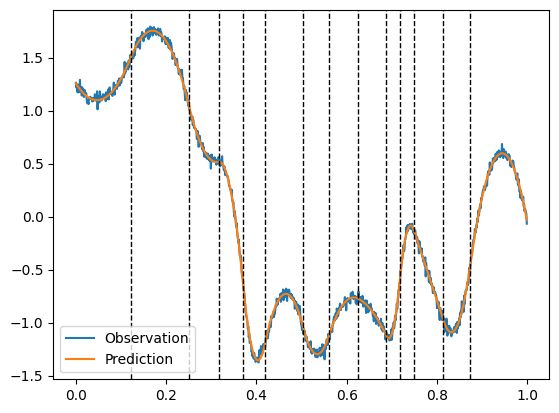

In [77]:
f, ax = plt.subplots()
ax.plot(x,y_obs, label="Observation")
ax.plot(x,predicted_polynomial(x), label="Prediction")
for bkp in b:
    ax.axvline(bkp,ls="--", color='k',lw=1)
plt.legend()
plt.plot()